In [5]:

import numpy as np
import tensorflow as tf
import os
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from models.CNN import create_cnn_model
import datetime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import json


In [6]:
def load(f):
    # Move up one directory when loading the data
    file_path = os.path.join('../../../', f)
    return np.load(file_path)['arr_0']

# Load the data
X_train = load('kmnist-train-imgs.npz')/255.0
x_test = load('kmnist-test-imgs.npz')/255.0
Y_train = load('kmnist-train-labels.npz')
y_test = load('kmnist-test-labels.npz')
# Reshape the data for CNN input
X_train = X_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [7]:
# Define the input shape and number of classes
input_shape = X_train.shape[1:]  # 784 for KMNIST
num_classes = Y_train.max() + 1

In [8]:
hyperparameters = {
    'num_layers': 3,
    'filters': [32, 64, 64],
    'kernel_sizes': [(3, 3), (3, 3), (3, 3)],
    'activations': ['relu', 'relu', 'relu'],
    'dense_units': 64,
    'dense_activation': 'relu'
}
configs = [
    {'batch_normalization': False, 'pooling': 'max'},
    {'batch_normalization': True, 'pooling': 'max'},
    {'batch_normalization': False, 'pooling': 'avg'},
    {'batch_normalization': True, 'pooling': 'avg'}
]
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
best_config = None
best_accuracy = 0
histories = []

test_loss_df = pd.DataFrame()
test_accuracy_df = pd.DataFrame()



for config in configs:
    print(f"Testing configuration: {config}")
    hyperparameters.update(config)
    model = create_cnn_model(input_shape, num_classes, hyperparameters)
    history = model.fit(x_train, y_train,
                        epochs=20,
                        batch_size=32,
                        validation_data=(x_val, y_val),
                        verbose=1,
                        callbacks=[early_stopping])
    # Learning curve
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Learning Curve for Config: {config["pooling"]} {config["batch_normalization"]}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    now = datetime.datetime.now()
    plt.savefig(f'learning_curve_{config["pooling"]}_{config["batch_normalization"]}_{now.strftime("%Y-%m-%d")}.png')
    plt.close()
    # Append the last value of val_loss and val_accuracy an additional ten times
    last_val_loss = history.history['val_loss'][-1]
    last_val_accuracy = history.history['val_accuracy'][-1]
    for _ in range(len(history.history['val_loss']), 100):
        history.history['val_loss'].append(last_val_loss)
        history.history['val_accuracy'].append(last_val_accuracy)
    test_loss_df[f"{config['pooling']} {config['batch_normalization']}"] = history.history['val_loss']
    test_accuracy_df[f"{config['pooling']} {config['batch_normalization']}"] = history.history['val_accuracy']


    # Predictions on the validation set
    y_pred = model.predict(x_test)
    y_pred_class = np.argmax(y_pred, axis=1)
    # Confusion matrix
    confusion = confusion_matrix(y_test, y_pred_class)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion)
    disp.plot()

    plt.title(f'Confusion Matrix for Config: {config["pooling"]} {config["batch_normalization"]}')
    plt.savefig(f'confusion_matrix_{config["pooling"]}_{config["batch_normalization"]}_{now.strftime("%Y-%m-%d")}.png')
    plt.close()
    histories.append(history)
    final_acc = max(history.history['val_accuracy'])

    if final_acc > best_accuracy:
        best_accuracy = final_acc
        best_config = config
print(f"Best configuration: {best_config}")
print(f"Best accuracy: {best_accuracy}")
# Train the best model on the full training set and evaluate on test set
print("Training best model on full training set...")
hyperparameters = hyperparameters.copy()
hyperparameters.update(best_config)

# Create and compile the best model
best_model = create_cnn_model(input_shape, num_classes, hyperparameters)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Train on the full training set
history = best_model.fit(x_train, y_train, 
                         epochs=100, 
                         batch_size=16, 
                         validation_data=(x_val, y_val),
                         callbacks=[early_stopping],
                         verbose=1)
# Append the last value of val_loss and val_accuracy an additional # of times so it can be plotted on same graph as other models
last_val_loss = history.history['val_loss'][-1]
last_val_accuracy = history.history['val_accuracy'][-1]
for _ in range(len(history.history['val_loss']), 100):
    history.history['val_loss'].append(last_val_loss)
    history.history['val_accuracy'].append(last_val_accuracy)
# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")
plt.figure(figsize=(10, 5))
# Plot the learnin curve of the best model
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Learning Curve for Best Model: {best_config["pooling"]} {best_config["batch_normalization"]}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
now = datetime.datetime.now()
plt.savefig(f'learning_curve_best_{best_config["pooling"]}_{best_config["batch_normalization"]}_{now.strftime("%Y-%m-%d")}.png')
plt.close()
# Predictions on the test set
y_pred = best_model.predict(x_test)
y_pred_class = np.argmax(y_pred, axis=1)

# Confusion matrix
confusion = confusion_matrix(y_test, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion)
disp.plot()
plt.title(f'Confusion Matrix for Best Model: {best_config["pooling"]} {best_config["batch_normalization"]}')
plt.savefig(f'confusion_matrix_best_{best_config["pooling"]}_{best_config["batch_normalization"]}_{now.strftime("%Y-%m-%d")}.png')
plt.close()
# Add the "best + config" column
test_loss_df[f"best {best_config['pooling']} {best_config['batch_normalization']}"] = history.history['val_loss']
test_accuracy_df[f"best {best_config['pooling']} {best_config['batch_normalization']}"] = history.history['val_accuracy']

# Save the dataframes to CSV files
test_loss_df.to_csv('test_loss.csv', index=False)
test_accuracy_df.to_csv('test_accuracy.csv', index=False)





Testing configuration: {'batch_normalization': False, 'pooling': 'max'}
Epoch 1/20
1688/1688 [==============================] - 7s 4ms/step - loss: 0.4720 - accuracy: 0.8490 - val_loss: 0.2665 - val_accuracy: 0.9190
Epoch 2/20
1688/1688 [==============================] - 7s 4ms/step - loss: 0.1775 - accuracy: 0.9446 - val_loss: 0.1600 - val_accuracy: 0.9487
Epoch 3/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.1211 - accuracy: 0.9625 - val_loss: 0.1345 - val_accuracy: 0.9548
Epoch 4/20
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0912 - accuracy: 0.9716 - val_loss: 0.1098 - val_accuracy: 0.9640
Epoch 5/20
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0718 - accuracy: 0.9772 - val_loss: 0.1086 - val_accuracy: 0.9653
Epoch 6/20
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0550 - accuracy: 0.9820 - val_loss: 0.1061 - val_accuracy: 0.9682
Epoch 7/20
1688/1688 [==============================] - 6s 4ms/s

In [9]:
print(best_accuracy)

0.9911666512489319


In [10]:
with open('hyperparameters.json', 'w') as f:
    json.dump(hyperparameters, f)

In [11]:
def cutout(image, mask_size=16, num_cutouts=1):
    """Applies Cutout augmentation to an image."""
    h, w, _ = image.shape
    image_copy = image.copy()

    for _ in range(num_cutouts):
        x = np.random.randint(0, w)
        y = np.random.randint(0, h)

        # Ensure the cutout does not go out of bounds
        x1 = np.clip(x - mask_size // 2, 0, w)
        x2 = np.clip(x + mask_size // 2, 0, w)
        y1 = np.clip(y - mask_size // 2, 0, h)
        y2 = np.clip(y + mask_size // 2, 0, h)

        # Set the cutout region to the mean value of the image
        mask_color = np.mean(image_copy)
        image_copy[y1:y2, x1:x2, :] = mask_color

    return image_copy

In [12]:
# Random noise
def add_random_noise(image, noise_factor=0.1):
    """Adds random noise to an image."""
    noisy_image = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    return np.clip(noisy_image, 0.0, 1.0)

def add_radial_noise(image, noise_factor=0.1):
    """Adds radial noise to an image."""
    h, w, _ = image.shape
    center_y, center_x = h // 2, w // 2
    y, x = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    max_dist = np.sqrt(center_x**2 + center_y**2)
    normalized_dist = dist_from_center / max_dist
    noise = np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    radial_noise = noise * normalized_dist[:, :, np.newaxis] * noise_factor
    noisy_image = image + radial_noise
    return np.clip(noisy_image, 0.0, 1.0)

def add_mask(image, mask_size=16, num_masks=1):
    """Adds random masks to an image."""
    masked_image = image.copy()
    h, w, _ = image.shape
    for _ in range(num_masks):
        y = np.random.randint(0, h - mask_size)
        x = np.random.randint(0, w - mask_size)
        masked_image[y:y+mask_size, x:x+mask_size, :] = 0
    return masked_image

def add_random_noise_mask(image):
    altered_image = add_random_noise(image)
    altered_image = add_mask(altered_image)
    return altered_image

datagen_rand_noise = ImageDataGenerator(
    preprocessing_function=add_random_noise  # Noise injection
)

# Radial noise
datagen_radial_noise = ImageDataGenerator(
    preprocessing_function=add_radial_noise  # Radial noise injection
)

# Flip
datagen_flip = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True
)

# Zoom
datagen_zoom = ImageDataGenerator(
    zoom_range=0.5 # Zoom in on the image
)

# Mask
datagen_mask = ImageDataGenerator(
    preprocessing_function = cutout  # Zoom in on the image
)

# Random noise and zoom
datagen_rand_noise_zoom = ImageDataGenerator(
    preprocessing_function=add_random_noise,  # Noise injection
    zoom_range=0.1 # Zoom in on the image
)

# Random noise and mask
datagen_rand_noise_mask = ImageDataGenerator(
    preprocessing_function=add_random_noise_mask,  # Noise injection
)

# No noise
datagen_no_noise = ImageDataGenerator()

Text(0.5, 1.0, 'Noise + Mask')

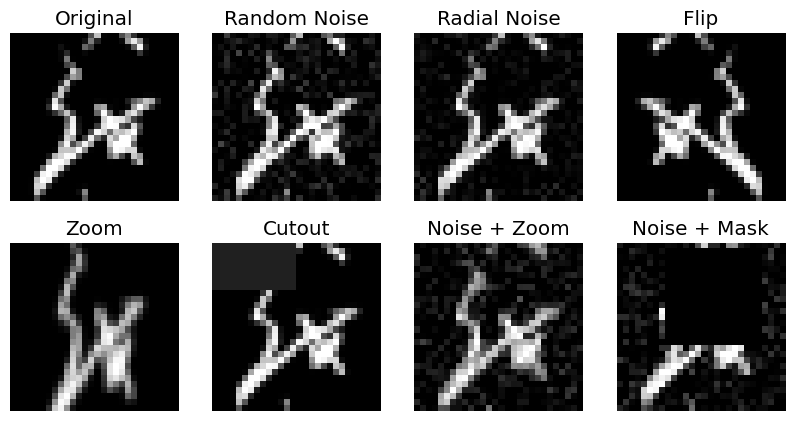

In [13]:
# Get a sample image
sample_image = x_train[0]
img_arr = img_to_array(sample_image) 
img_arr = img_arr.reshape((1,) + img_arr.shape)
# Apply different augmentations
augmented_images = []
# For the other augmentations, we can use the existing datagenerators

# Apply each datagen separately to the same image
augmented_images.append(img_arr)  # Original image

# Random Noise
augmented_images.append(datagen_rand_noise.flow(img_arr, batch_size=1))

# Radial Noise
augmented_images.append(datagen_radial_noise.flow(img_arr, batch_size=1))

# Flip
augmented_images.append(datagen_flip.flow(img_arr, batch_size=1))

# Zoom
augmented_images.append(datagen_zoom.flow(img_arr, batch_size=1))

# Mask (Cutout)
augmented_images.append(datagen_mask.flow(img_arr, batch_size=1))

# Random Noise + Zoom
augmented_images.append(datagen_rand_noise_zoom.flow(img_arr, batch_size=1))

# No Augmentation
augmented_images.append(datagen_rand_noise_mask.flow(img_arr, batch_size=1))

f, xyarr = plt.subplots(2, 4, figsize=(10, 5))
for ax in xyarr.flat:
    ax.axis('off')  # This removes all axes, including scale bars
plt.rcParams.update({'font.size': 12})  # Increase font size
xyarr[0,0].imshow(augmented_images[0][0].squeeze(), cmap='gray')
xyarr[0,0].set_title('Original')
xyarr[0,1].imshow(augmented_images[1][0].squeeze(), cmap='gray')
xyarr[0,1].set_title('Random Noise')
xyarr[0,2].imshow(augmented_images[2][0].squeeze(), cmap='gray')
xyarr[0,2].set_title('Radial Noise')
xyarr[0,3].imshow(augmented_images[3][0].squeeze(), cmap='gray')
xyarr[0,3].set_title('Flip')    
xyarr[1,0].imshow(augmented_images[4][0].squeeze(), cmap='gray')
xyarr[1,0].set_title('Zoom')
xyarr[1,1].imshow(augmented_images[5][0].squeeze(), cmap='gray')
xyarr[1,1].set_title('Cutout')
xyarr[1,2].imshow(augmented_images[6][0].squeeze(), cmap='gray')
xyarr[1,2].set_title('Noise + Zoom')
xyarr[1,3].imshow(augmented_images[7][0].squeeze(), cmap='gray')
xyarr[1,3].set_title('Noise + Mask')



In [14]:
# Load the hyperparameters
hyperparameters = json.load(open('hyperparameters.json'))
print(hyperparameters)
# Create the models with different noise injection
best_model_rand_noise = create_cnn_model(input_shape, num_classes, hyperparameters)
best_model_radial_noise = create_cnn_model(input_shape, num_classes, hyperparameters)
best_model_flip = create_cnn_model(input_shape, num_classes, hyperparameters)
best_model_zoom = create_cnn_model(input_shape, num_classes, hyperparameters)
best_model_mask = create_cnn_model(input_shape, num_classes, hyperparameters)
best_model_rand_noise_zoom = create_cnn_model(input_shape, num_classes, hyperparameters)
best_model_rand_noise_mask = create_cnn_model(input_shape, num_classes, hyperparameters)
best_model_no_noise = create_cnn_model(input_shape, num_classes, hyperparameters)



datagen_val = ImageDataGenerator()
# Wrap the datagen with our custom generator
train_generator_rand_noise = datagen_rand_noise.flow(x_train, y_train, batch_size=32)
train_generator_radial_noise = datagen_radial_noise.flow(x_train, y_train, batch_size=32)
train_generator_flip = datagen_flip.flow(x_train, y_train, batch_size=32)
train_generator_zoom = datagen_zoom.flow(x_train, y_train, batch_size=32)
train_generator_mask = datagen_mask.flow(x_train, y_train, batch_size=32)
train_generator_rand_noise_zoom = datagen_rand_noise_zoom.flow(x_train, y_train, batch_size=32)
train_generator_rand_noise_mask = datagen_rand_noise_mask.flow(x_train, y_train, batch_size=32)
train_generator_no_noise = datagen_no_noise.flow(x_train, y_train, batch_size=32)
val_generator = datagen_val.flow(x_val, y_val, batch_size=32)
# Train the model with custom augmentation
augmentation_loss_df = pd.DataFrame()
augmentation_accuracy_df = pd.DataFrame()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Random noise
history_rand_noise = best_model_rand_noise.fit(train_generator_rand_noise,
                        epochs=15,
                        validation_data=val_generator,  
                        verbose=1,
                        callbacks=[early_stopping]
                        )
last_val_loss = history_rand_noise.history['val_loss'][-1]
last_val_accuracy = history_rand_noise.history['val_accuracy'][-1]
for _ in range(len(history_rand_noise.history['val_loss']), 16):
    history_rand_noise.history['val_loss'].append(last_val_loss)
    history_rand_noise.history['val_accuracy'].append(last_val_accuracy)
augmentation_loss_df[f"rand_noise"] = history_rand_noise.history['val_loss']
augmentation_accuracy_df[f"rand_noise"] = history_rand_noise.history['val_accuracy']

# Radial noise
history_radial_noise = best_model_radial_noise.fit(train_generator_radial_noise,
                        epochs=15,
                        validation_data=val_generator,  
                        verbose=1,
                        callbacks=[early_stopping]
                        )
last_val_loss = history_radial_noise.history['val_loss'][-1]
last_val_accuracy = history_radial_noise.history['val_accuracy'][-1]
for _ in range(len(history_radial_noise.history['val_loss']), 16):
    history_radial_noise.history['val_loss'].append(last_val_loss)
    history_radial_noise.history['val_accuracy'].append(last_val_accuracy)
augmentation_loss_df[f"radial_noise"] = history_radial_noise.history['val_loss']
augmentation_accuracy_df[f"radial_noise"] = history_radial_noise.history['val_accuracy']


# Flip
history_flip = best_model_flip.fit(train_generator_flip,
                        epochs=15,
                        validation_data=val_generator,
                        verbose=1,
                        callbacks=[early_stopping]
                        )
last_val_loss = history_flip.history['val_loss'][-1]
last_val_accuracy = history_flip.history['val_accuracy'][-1]
for _ in range(len(history_flip.history['val_loss']), 16):
    history_flip.history['val_loss'].append(last_val_loss)
    history_flip.history['val_accuracy'].append(last_val_accuracy)
augmentation_loss_df[f"flip"] = history_flip.history['val_loss']
augmentation_accuracy_df[f"flip"] = history_flip.history['val_accuracy']

# Zoom
history_zoom = best_model_zoom.fit(train_generator_zoom,
                        epochs=15,
                        validation_data=val_generator,
                        verbose=1,
                        callbacks=[early_stopping]
                        )
last_val_loss = history_zoom.history['val_loss'][-1]
last_val_accuracy = history_zoom.history['val_accuracy'][-1]
for _ in range(len(history_zoom.history['val_loss']), 16):
    history_zoom.history['val_loss'].append(last_val_loss)
    history_zoom.history['val_accuracy'].append(last_val_accuracy)
augmentation_loss_df[f"zoom"] = history_zoom.history['val_loss']
augmentation_accuracy_df[f"zoom"] = history_zoom.history['val_accuracy']

# Mask
history_mask = best_model_mask.fit(train_generator_mask,
                        epochs=15,
                        validation_data=val_generator,
                        verbose=1,
                        callbacks=[early_stopping]
                        )
last_val_loss = history_mask.history['val_loss'][-1]
last_val_accuracy = history_mask.history['val_accuracy'][-1]
for _ in range(len(history_mask.history['val_loss']), 16):
    history_mask.history['val_loss'].append(last_val_loss)
    history_mask.history['val_accuracy'].append(last_val_accuracy)
augmentation_loss_df[f"mask"] = history_mask.history['val_loss']
augmentation_accuracy_df[f"mask"] = history_mask.history['val_accuracy']

# Rand noise and zoom
history_rand_noise_zoom = best_model_rand_noise_zoom.fit(train_generator_rand_noise_zoom,
                        epochs=15,
                        validation_data=val_generator,
                        verbose=1,
                        callbacks=[early_stopping]
                        )
last_val_loss = history_rand_noise_zoom.history['val_loss'][-1]
last_val_accuracy = history_rand_noise_zoom.history['val_accuracy'][-1]
for _ in range(len(history_rand_noise_zoom.history['val_loss']), 16):
    history_rand_noise_zoom.history['val_loss'].append(last_val_loss)
    history_rand_noise_zoom.history['val_accuracy'].append(last_val_accuracy)
augmentation_loss_df[f"rand_noise_zoom"] = history_rand_noise_zoom.history['val_loss']
augmentation_accuracy_df[f"rand_noise_zoom"] = history_rand_noise_zoom.history['val_accuracy']

# Random noise and mask
history_rand_noise_mask = best_model_rand_noise_mask.fit(train_generator_rand_noise_mask,
                        epochs=15,
                        validation_data=val_generator,
                        verbose=1,
                        callbacks=[early_stopping]
                        )
last_val_loss = history_rand_noise_mask.history['val_loss'][-1]
last_val_accuracy = history_rand_noise_mask.history['val_accuracy'][-1]
for _ in range(len(history_rand_noise_mask.history['val_loss']), 16):
    history_rand_noise_mask.history['val_loss'].append(last_val_loss)
    history_rand_noise_mask.history['val_accuracy'].append(last_val_accuracy)
augmentation_loss_df[f"rand_noise_mask"] = history_rand_noise_mask.history['val_loss']
augmentation_accuracy_df[f"rand_noise_mask"] = history_rand_noise_mask.history['val_accuracy']

# No noise
history_no_noise = best_model_no_noise.fit(train_generator_no_noise,
                        epochs=15,
                        validation_data=val_generator,
                        verbose=1,
                        callbacks=[early_stopping]
                        )
last_val_loss = history_no_noise.history['val_loss'][-1]
last_val_accuracy = history_no_noise.history['val_accuracy'][-1]
for _ in range(len(history_no_noise.history['val_loss']), 16):
    history_no_noise.history['val_loss'].append(last_val_loss)
    history_no_noise.history['val_accuracy'].append(last_val_accuracy)
augmentation_loss_df[f"no_noise"] = history_no_noise.history['val_loss']
augmentation_accuracy_df[f"no_noise"] = history_no_noise.history['val_accuracy']

# Save the dataframes to CSV files
augmentation_loss_df.to_csv('augmentation_loss.csv', index=False)
augmentation_accuracy_df.to_csv('augmentation_accuracy.csv', index=False)



{'num_layers': 3, 'filters': [32, 64, 64], 'kernel_sizes': [[3, 3], [3, 3], [3, 3]], 'activations': ['relu', 'relu', 'relu'], 'dense_units': 64, 'dense_activation': 'relu', 'batch_normalization': True, 'pooling': 'avg'}
Epoch 1/15
1688/1688 [==============================] - 13s 8ms/step - loss: 0.1970 - accuracy: 0.9482 - val_loss: 0.1445 - val_accuracy: 0.9525
Epoch 2/15
1688/1688 [==============================] - 12s 7ms/step - loss: 0.0730 - accuracy: 0.9787 - val_loss: 0.0934 - val_accuracy: 0.9720
Epoch 3/15
1688/1688 [==============================] - 12s 7ms/step - loss: 0.0527 - accuracy: 0.9840 - val_loss: 0.0658 - val_accuracy: 0.9813
Epoch 4/15
1688/1688 [==============================] - 13s 8ms/step - loss: 0.0392 - accuracy: 0.9882 - val_loss: 0.0511 - val_accuracy: 0.9847
Epoch 5/15
1688/1688 [==============================] - 12s 7ms/step - loss: 0.0320 - accuracy: 0.9898 - val_loss: 0.0485 - val_accuracy: 0.9847
Epoch 6/15
1688/1688 [==============================] -

In [15]:
rand_noise_loss, rand_noise_accuracy = best_model_rand_noise.evaluate(x_test, y_test, verbose=0)
print(f"Rand noise test accuracy: {rand_noise_accuracy:.4f}")
print(f"Rand noise test loss: {rand_noise_loss:.4f}")
radial_noise_loss, radial_noise_accuracy = best_model_radial_noise.evaluate(x_test, y_test, verbose=0)
print(f"Radial noise test accuracy: {radial_noise_accuracy:.4f}")
print(f"Radial noise test loss: {radial_noise_loss:.4f}")
flip_loss, flip_accuracy = best_model_flip.evaluate(x_test, y_test, verbose=0)
print(f"Flip test accuracy: {flip_accuracy:.4f}")
print(f"Flip test loss: {flip_loss:.4f}")
zoom_loss, zoom_accuracy = best_model_zoom.evaluate(x_test, y_test, verbose=0)
print(f"Zoom test accuracy: {zoom_accuracy:.4f}")
print(f"Zoom test loss: {zoom_loss:.4f}")
mask_loss, mask_accuracy = best_model_mask.evaluate(x_test, y_test, verbose=0)
print(f"Mask test accuracy: {mask_accuracy:.4f}")
print(f"Mask test loss: {mask_loss:.4f}")
rand_noise_zoom_loss, rand_noise_zoom_accuracy = best_model_rand_noise_zoom.evaluate(x_test, y_test, verbose=0)
print(f"Rand noise and zoom test accuracy: {rand_noise_zoom_accuracy:.4f}")
print(f"Rand noise and zoom test loss: {rand_noise_zoom_loss:.4f}")
rand_noise_mask_loss, rand_noise_mask_accuracy = best_model_rand_noise_mask.evaluate(x_test, y_test, verbose=0)
print(f"Rand noise and mask test accuracy: {rand_noise_mask_accuracy:.4f}")
print(f"Rand noise and mask test loss: {rand_noise_mask_loss:.4f}")
no_noise_loss, no_noise_accuracy = best_model_no_noise.evaluate(x_test, y_test, verbose=0)
print(f"No noise test accuracy: {no_noise_accuracy:.4f}")
print(f"No noise test loss: {no_noise_loss:.4f}")


Rand noise test accuracy: 0.9676
Rand noise test loss: 0.1507
Radial noise test accuracy: 0.9590
Radial noise test loss: 0.1452
Flip test accuracy: 0.9489
Flip test loss: 0.1888
Zoom test accuracy: 0.9612
Zoom test loss: 0.1526
Mask test accuracy: 0.9679
Mask test loss: 0.1315
Rand noise and zoom test accuracy: 0.9663
Rand noise and zoom test loss: 0.1416
Rand noise and mask test accuracy: 0.9366
Rand noise and mask test loss: 0.2489
No noise test accuracy: 0.9481
No noise test loss: 0.1800


In [16]:
# List of models and their names
models = [
    (best_model_rand_noise, "Random Noise"),
    (best_model_radial_noise, "Radial Noise"),
    (best_model_flip, "Flip"),
    (best_model_zoom, "Zoom"),
    (best_model_mask, "Mask"),
    (best_model_rand_noise_zoom, "Random Noise + Zoom"),
    (best_model_rand_noise_mask, "Random Noise + Mask"),
    (best_model_no_noise, "No Noise")
]

# Create and save confusion matrices for each model
for model, name in models:
    # Predictions on the test set
    y_pred = model.predict(x_test)
    y_pred_class = np.argmax(y_pred, axis=1)

    # Confusion matrix
    confusion = confusion_matrix(y_test, y_pred_class)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax)
    plt.title(f'Confusion Matrix for {name}')
    
    # Save the figure
    now = datetime.datetime.now()
    plt.savefig(f'confusion_matrix_{name.replace(" ", "_").lower()}_{now.strftime("%Y-%m-%d")}.png')
    plt.close()




313/313 [==============================] - 1s 2ms/step


In [27]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
best_model_mask_long = create_cnn_model(input_shape, num_classes, hyperparameters)
train_generator_mask_long = datagen_mask.flow(x_train, y_train, batch_size=16)
history_mask_long = best_model_mask_long.fit(train_generator_mask_long,
                        epochs=50,
                        validation_data=val_generator,
                        verbose=1,
                        callbacks=[early_stopping]
                        )
last_val_loss = history_mask_long.history['val_loss'][-1]
last_val_accuracy = history_mask_long.history['val_accuracy'][-1]
for _ in range(len(history_mask_long.history['val_loss']), 50):
    history_mask_long.history['val_loss'].append(last_val_loss)
    history_mask_long.history['val_accuracy'].append(last_val_accuracy)

best_model_rand_noise_zoom_long = create_cnn_model(input_shape, num_classes, hyperparameters)
train_generator_rand_noise_zoom_long = datagen_rand_noise_zoom.flow(x_train, y_train, batch_size=16)
history_rand_noise_zoom_long = best_model_rand_noise_zoom_long.fit(train_generator_rand_noise_zoom_long,
                        epochs=50,
                        validation_data=val_generator,
                        verbose=1,
                        callbacks=[early_stopping]
                        )
last_val_loss = history_rand_noise_zoom_long.history['val_loss'][-1]
last_val_accuracy = history_rand_noise_zoom_long.history['val_accuracy'][-1]
for _ in range(len(history_rand_noise_zoom_long.history['val_loss']), 50):
    history_rand_noise_zoom_long.history['val_loss'].append(last_val_loss)
    history_rand_noise_zoom_long.history['val_accuracy'].append(last_val_accuracy)

# Predictions on the test set for mask long model
y_pred_mask = best_model_mask.predict(x_test)
y_pred_mask_class = np.argmax(y_pred_mask, axis=1)
# Calculate and print accuracy for mask model
mask_accuracy = accuracy_score(y_test, y_pred_mask_class)
print(f"Mask Model Test Accuracy: {mask_accuracy:.4f}")



# Confusion matrix for mask long
confusion_mask = confusion_matrix(y_test, y_pred_mask_class)
disp_mask = ConfusionMatrixDisplay(confusion_matrix=confusion_mask)

# Plot mask long confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp_mask.plot(ax=ax)
plt.title('Confusion Matrix for Mask Long')

# Save the mask long figure
now = datetime.datetime.now()
plt.savefig(f'confusion_matrix_mask_long_{now.strftime("%Y-%m-%d")}.png')
plt.close()

# Predictions on the test set for noise zoom long model 
y_pred_noise = best_model_rand_noise_zoom.predict(x_test)
y_pred_noise_class = np.argmax(y_pred_noise, axis=1)
# Calculate and print accuracy for random noise zoom model 
noise_accuracy = accuracy_score(y_test, y_pred_noise_class)
print(f"Random Noise Zoom Model Test Accuracy: {noise_accuracy:.4f}")
# Confusion matrix for noise zoom long
confusion_noise = confusion_matrix(y_test, y_pred_noise_class)
disp_noise = ConfusionMatrixDisplay(confusion_matrix=confusion_noise)

# Plot noise zoom long confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp_noise.plot(ax=ax)
plt.title('Confusion Matrix for Random Noise Zoom Long')

# Save the noise zoom long figure
plt.savefig(f'confusion_matrix_random_noise_zoom_long_{now.strftime("%Y-%m-%d")}.png')
plt.close()
# Plot learning curves


Epoch 1/50
3375/3375 [==============================] - 18s 5ms/step - loss: 0.4245 - accuracy: 0.8686 - val_loss: 0.1133 - val_accuracy: 0.9658
Epoch 2/50
3375/3375 [==============================] - 18s 5ms/step - loss: 0.2301 - accuracy: 0.9258 - val_loss: 0.0722 - val_accuracy: 0.9775
Epoch 3/50
3375/3375 [==============================] - 18s 5ms/step - loss: 0.1935 - accuracy: 0.9372 - val_loss: 0.0495 - val_accuracy: 0.9850
Epoch 4/50
3375/3375 [==============================] - 18s 5ms/step - loss: 0.1692 - accuracy: 0.9451 - val_loss: 0.0347 - val_accuracy: 0.9903
Epoch 5/50
3375/3375 [==============================] - 18s 5ms/step - loss: 0.1500 - accuracy: 0.9518 - val_loss: 0.0554 - val_accuracy: 0.9830
Epoch 6/50
3375/3375 [==============================] - 17s 5ms/step - loss: 0.1354 - accuracy: 0.9563 - val_loss: 0.0339 - val_accuracy: 0.9903
Epoch 7/50
3375/3375 [==============================] - 18s 5ms/step - loss: 0.1296 - accuracy: 0.9583 - val_loss: 0.0342 - val_ac

In [29]:
plt.figure(figsize=(10, 8))

# Plot training & validation loss values for mask model
plt.plot(history_mask_long.history['val_accuracy'], label='Validation Accuracy Mask ')
plt.plot(history_rand_noise_zoom_long.history['val_accuracy'], label='Validation Accuracy Random Noise Zoom')
plt.title('Augmentation Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig(f'learning_curves_{now.strftime("%Y-%m-%d")}.png')
plt.close()
